In [2]:
from importlib import reload
import re
import random
random.seed(1337)
import os
import pickle

import numpy as np
np.random.seed(1337)
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import backend as K
from keras.models import load_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import model
import utils

Using TensorFlow backend.


### Prepare data

In [18]:
seq_df = pd.read_csv("../Data/gencodev19_5utr_seq.csv")

In [34]:
pos_df = pd.read_csv("../Data/gencodev19_5utr_pos.csv")

In [119]:
# remove length 1 utrs, as they can not yield sensible predictions and only mess with numpy
pos_df = pos_df[pos_df["EnsemblTranscriptID"].
                isin(seq_df[seq_df["utr"].str.len() > 1]["EnsemblTranscriptID"])]

In [373]:
nuc_dict = {'a':[1.0,0.0,0.0,0.0],'c':[0.0,1.0,0.0,0.0],'g':[0.0,0.0,1.0,0.0], 'u':[0.0,0.0,0.0,1.0], 
            't':[0.0,0.0,0.0,1.0], 'n':[0.0,0.0,0.0,0.0], 'x':[1/4,1/4,1/4,1/4]}
permutation_array = np.array([[1.0,0.0,0.0,0.0], [0.0,1.0,0.0,0.0], [0.0,0.0,1.0,0.0], [0.0,0.0,0.0,1.0]])

def create_permutations(seq):
    n = len(seq) * 4
    seq = seq.lower()
    one_hot = np.array([nuc_dict[x] for x in seq])
    one_hot_permuted = np.repeat(one_hot[np.newaxis,:,:], n, axis=0)
    for i in range(len(seq)):
        one_hot_permuted[i*4:(i*4)+4,i] = permutation_array
    one_hot_permuted = np.concatenate([one_hot[np.newaxis,:,:], one_hot_permuted], axis=0)
    indicator = np.zeros((n+1,6))
    indicator[np.arange(n+1), 0] = 1
    return [one_hot_permuted, indicator]

def write_arrays(df, path):
    for seq_id, seq in zip(df["EnsemblTranscriptID"], df["utr"]):
        #ls.append(seq_id)
        if len(seq) == 1:
            continue
        predictions = new_model.predict(create_permutations(seq))
        delta = np.log2(predictions[1:]/predictions[0])
        delta = delta.reshape((len(seq), 4))
        np.save(path + "SNPdelta_" + seq_id + ".npy", np.transpose(delta))
        
def read_array(pos_df, transcript_id, base_path = "../Data/All_Variants/",
              snv_path="Genecode_v19/", cons_path="phylop/", gnomad_path="gnomad/"):
    array = np.load(base_path + snv_path + "SNPdelta_" + transcript_id + ".npy")
    pos = pos_df[pos_df.EnsemblTranscriptID == transcript_id].iloc[0]
    indices = np.concatenate([np.arange(x[0],x[1]) for x in eval(pos["pos"])])
    conservation = np.load(base_path + cons_path + "phyloP_" + transcript_id + ".npy")
    if pos["strand"] == "-":
        indices = np.flip(indices)
        conservation = np.flip(conservation)
    gnomad = np.transpose(np.load(base_path + gnomad_path + "gnomad_" + transcript_id + ".npy"))
    return pd.DataFrame({"EnsemblTranscriptID":pos["EnsemblTranscriptID"], 
                         "chr":pos["chr"], "strand":pos["strand"], "pos_ensembl":indices+1,
                         "conservation":conservation,
                        "A":array[0,:],"C":array[1,:],"G":array[2,:],"T":array[3,:],
                        "gnomadA":gnomad[0,:],"gnomadC":gnomad[1,:],
                         "gnomadG":gnomad[2,:],"gnomadT":gnomad[3,:]})

def read_all_arrays(pos_df):
    data = []
    i = 0
    for transcript_id in pos_df["EnsemblTranscriptID"]:
        arr = read_array(pos_df, transcript_id)
        data.append(arr)
        if i % 1000 == 0:
            print(i)
        i += 1
    arr = pd.concat(data)
    return arr

### Predict SNV effects

In [55]:
new_model = load_model("../Models/basic_model_scaled.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

In [ ]:
write_arrays(seq_df, "../Data/All_Variants/Genecode_v19/")

### Subset to LoF intolerant genes

In [152]:
lof_df = pd.read_csv("../Data/GTF/gencodev19_5utr_lof.bed", sep="\t",
                     names=["chr", "start", "stop", "EnsemblTranscriptID", "?", "strand"])

In [154]:
pos_df = pos_df[pos_df["EnsemblTranscriptID"].isin(lof_df["EnsemblTranscriptID"])]

In [374]:
arr = read_all_arrays(pos_df)

0
1000
2000
3000
4000
5000
6000
7000
8000


In [380]:
arr["max_effect"] = np.max(np.abs(np.array(arr[["A","C","G","T"]])), axis = 1)

In [375]:
arr["avg_effect"] = np.sum(np.abs(np.array(arr[["A","C","G","T"]])), axis = 1)/3

### Compare to conservation scores

In [376]:
arr_effect = arr.copy().dropna()
#arr_effect = arr_effect[arr_effect["avg_effect"] > 0.01]

In [377]:
utils.print_corrs(arr_effect["avg_effect"], arr_effect["conservation"])

Pearson: 0.056, p-val: 0.000, squared: 0.003, Spearman: 0.054, p-val: 0.000


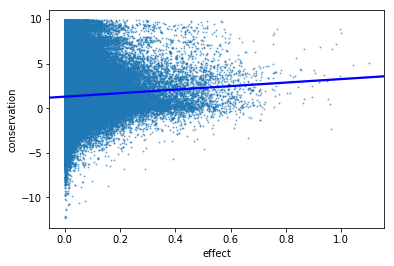

In [262]:
df = pd.DataFrame({"effect":arr_effect["avg_effect"], "conservation":arr_effect["conservation"]})
x = sns.regplot(x='effect', y="conservation", data=df, line_kws={"color":"b"}, scatter_kws={"s": 1, "alpha":0.5}).get_figure()

In [281]:
x.savefig("../Graphics/phylop_corr.png")

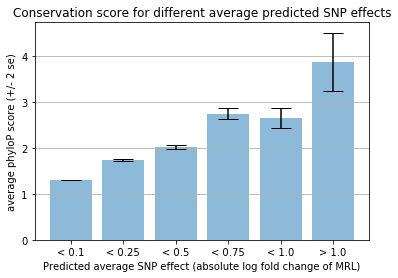

In [383]:
cuts = [0, 0.1, 0.25, 0.5, 0.75, 1.0]
cuts2 = cuts[1:] + [100]
scores = []
sem = []
for l,u in zip(cuts, cuts2):
    scores.append(arr[(arr["avg_effect"] < u) & (arr["avg_effect"] > l)]["conservation"].mean())
    sem.append(arr[(arr["avg_effect"] < u) & (arr["avg_effect"] > l)]["conservation"].sem() * 2)
x_pos = np.arange(len(scores))
names = ["< " + str(x) for x in cuts2[:-1]] + ["> " + str(cuts[-1])]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, scores, yerr=sem, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('average phyloP score (+/- 2 se)')
ax.set_xticks(x_pos)
ax.set_xticklabels(names)
ax.set_xlabel("Predicted average SNP effect (absolute log fold change of MRL)")
ax.set_title('Conservation score for different average predicted SNP effects')
ax.yaxis.grid(True)
fig.savefig("../Graphics/phylop_bar.svg")

In [390]:
arr_strong = arr[arr["avg_effect"] > 1]

In [391]:
arr_strong[(arr_strong.conservation > 5)]

,EnsemblTranscriptID,chr,strand,pos_ensembl,conservation,A,C,G,T,gnomadA,gnomadC,gnomadG,gnomadT,avg_effect,max_effect
45,ENST00000042381,chr16,+,67572327,6.621,1.290852,1.290171,0.000000,1.287262,0.000000,0.0,0.000000,0.000000,1.289428,1.290852
9,ENST00000225430,chr17,+,37356545,6.864,1.206781,1.222825,0.000000,1.255511,0.000000,0.0,0.000000,0.000000,1.228372,1.255511
61,ENST00000335263,chr14,+,102606242,8.430,0.000000,1.001927,1.003513,1.022594,0.000000,0.0,0.000004,0.000004,1.009345,1.022594
62,ENST00000335263,chr14,+,102606243,7.252,1.006552,0.997541,1.002188,0.000000,0.000000,0.0,0.000004,0.000000,1.002094,1.006552
63,ENST00000335263,chr14,+,102606244,8.910,1.028261,1.011880,0.000000,1.033771,0.000008,0.0,0.000000,0.000000,1.024638,1.033771
13,ENST00000336483,chr5,+,67586478,5.645,0.000000,1.095937,1.131247,1.121363,0.000000,0.0,0.000000,0.000000,1.116182,1.131247
12,ENST00000342702,chr14,+,102606242,8.430,0.000000,1.320277,1.325752,1.342789,0.000000,0.0,0.000004,0.000004,1.329606,1.342789
13,ENST00000342702,chr14,+,102606243,7.252,1.311660,1.286020,1.320131,0.000000,0.000000,0.0,0.000004,0.000000,1.305937,1.320131
14,ENST00000342702,chr14,+,102606244,8.910,1.333212,1.313172,0.000000,1.341615,0.000008,0.0,0.000000,0.000000,1.329333,1.341615
98,ENST00000379312,chr16,+,67572327,6.621,1.138036,1.176936,0.000000,1.148849,0.000000,0.0,0.000000,0.000000,1.154607,1.176936


In [416]:
arr_C = arr[(arr.index < 2) & (arr.max_effect > 0.5)]

In [417]:
arr_C

,EnsemblTranscriptID,chr,strand,pos_ensembl,conservation,A,C,G,T,gnomadA,gnomadC,gnomadG,gnomadT,avg_effect,max_effect
1,ENST00000217402,chr20,+,32399111,1.772,-0.676444,0.016939,0.000000,0.057269,0.000000,0.000000,0.000000,0.000000,0.250218,0.676444
0,ENST00000220959,chr8,-,103424917,0.837,0.584371,0.580976,0.592461,0.000000,0.000000,0.000000,0.000000,0.000000,0.585936,0.592461
1,ENST00000220959,chr8,-,103424916,0.556,0.609890,0.597349,0.000000,0.605389,0.002958,0.000000,0.000000,0.000000,0.604209,0.609890
1,ENST00000226247,chr17,+,26850960,-0.585,-0.000232,0.000000,-0.018224,-0.774396,0.000004,0.000000,0.000000,0.000105,0.264284,0.774396
1,ENST00000229340,chr12,-,120554642,0.154,0.000000,-0.012617,0.012620,-0.730103,0.000000,0.000000,0.000000,0.000000,0.251780,0.730103
0,ENST00000233078,chr19,+,1407612,2.338,-0.017664,-0.059904,0.000000,-0.514305,0.000000,0.000000,0.000000,0.000000,0.197291,0.514305
1,ENST00000246801,chr19,-,50266586,0.185,-0.503772,0.001166,0.000000,0.005231,0.000013,0.000000,0.000000,0.000000,0.170056,0.503772
1,ENST00000250241,chr19,+,10781214,1.588,0.000000,-0.006591,0.001795,-0.552956,0.000000,0.000000,0.000000,0.000000,0.187114,0.552956
1,ENST00000250894,chr16,+,1756185,0.222,-0.514355,0.001618,0.000000,-0.002584,0.000000,0.000000,0.000000,0.000000,0.172852,0.514355
1,ENST00000254695,chr17,+,2699733,-1.359,-0.580975,0.000000,-0.017843,-0.005432,0.000000,0.000000,0.000000,0.000000,0.201417,0.580975


In [403]:
# 
seq_df[seq_df.EnsemblTranscriptID == "ENST00000359606"].iloc[0]["utr"][18:]

'GCTAATTTTTGTTTAGTAGAG'

In [420]:
seq_df[seq_df.EnsemblTranscriptID == "ENST00000233078"].iloc[0]["utr"]


'GGAGGCAGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGCCGTTGCGCAGATCCGGGCCGCGGCTGTGGGGAGGGCGACGGAGCGGGTGACCTTCCGGAGGCGGGAGCGAGCGAGGAGGCCCGGGAGCGCCGAGCGTCGCCGCCGCCGCCGCC'

### Clinvar

In [371]:
clin = pd.read_csv("../Data/SNV/clinvar2.tsv", sep="\t")

### Gnomad

In [ ]:
arr["max_gnom"] = np.max(np.abs(np.array(arr[["gnomadA","gnomadC","gnomadG","gnomadT"]])), axis = 1)

In [194]:
sum(arr["max_gnom"] == 0)/len(arr)

0.9405489341393186

In [216]:
n1 = sum(arr["A"] < 0.05)
n2 = sum(arr["A"] > 0.5)
f1 = sum(arr[arr["A"] < 0.05]["gnomadA"] == 0)
f2 = sum(arr[arr["A"] > 0.5]["gnomadA"] == 0)

In [217]:
f1/n1

0.9802608672139707

In [218]:
f2/n2

0.9638476436410588

In [225]:
def compute_corr(arr, nt):
    arr_nt = arr.copy()
    arr_nt = arr_nt[arr_nt["gnomad" + nt] > 0]
    print(len(arr_nt))
    utils.print_corrs(arr[nt], arr["gnomad" + nt])

In [226]:
compute_corr(arr, "T")

50165
Pearson: 0.001, p-val: 0.373, squared: 0.000, Spearman: 0.027, p-val: 0.000


In [190]:
utils.print_corrs(arr["T"], arr["gnomadT"])

Pearson: 0.001, p-val: 0.373, squared: 0.000, Spearman: 0.027, p-val: 0.000


In [87]:
x = np.load("../Data/All_Variants/Genecode_v19/SNPdelta_ENST00000237247.npy")

In [353]:
path_list = ['Pathogenic', 'Likely pathogenic', 'Pathogenic, other', 'Pathogenic/Likely pathogenic']
path = sub[(sub['clin_sig'] == path_list[0]) | (sub['clin_sig'] == path_list[1]) |
           (sub['clin_sig'] == path_list[2]) | (sub['clin_sig'] == path_list[3])]

In [366]:
path_drp = path[np.isfinite(path["log_obs_diff"])]
path_drp.sort_values("log_obs_diff")[["log_pred_diff","log_obs_diff", "gene_symbol", "dbSNP"]]

,log_pred_diff,log_obs_diff,gene_symbol,dbSNP
1412,-1.025956,-1.496505,TMEM127,rs121908813
2461,0.045119,-0.899040,TTC19,rs769078093
2498,-0.661992,-0.644101,SMPD1,rs875989837
2651,-0.027425,-0.534640,MYLK,rs387906781
1749,0.023406,-0.265199,TP53,rs866775781
1900,-0.167186,-0.207727,PTEN,rs794729664
2992,0.006214,-0.196702,SLC6A1,rs1064795290
2923,-0.044997,-0.163921,APOA1,rs121912723
1901,-0.189942,-0.133596,PTEN,rs794729664
222,-0.032318,-0.129344,HFE2,rs74315327


In [369]:
path_drp[np.abs(path_drp["log_obs_diff"]) > 0.5][["log_pred_diff","log_obs_diff", "gene_symbol", "dbSNP"]]

,log_pred_diff,log_obs_diff,gene_symbol,dbSNP
644,0.111831,0.560054,GALT,rs111033654
842,0.073995,0.537494,GALT,rs111033656
843,0.061546,0.600583,GALT,rs111033656
1412,-1.025956,-1.496505,TMEM127,rs121908813
1452,1.602726,1.205073,SMAD3,rs587776882
2461,0.045119,-0.899040,TTC19,rs769078093
2498,-0.661992,-0.644101,SMPD1,rs875989837
2540,0.934110,1.147065,ACADM,rs1057516778
2651,-0.027425,-0.534640,MYLK,rs387906781


In [370]:
",".join(list(path_drp[np.abs(path_drp["log_obs_diff"]) > 0.5]["gene_symbol"]))

'GALT,GALT,GALT,TMEM127,SMAD3,TTC19,SMPD1,ACADM,MYLK'